In [ ]:
%pip install

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Load the Dataset

In [7]:
root = os.path.join(os.path.dirname(os.getcwd()), 'UMKC_DS_Capstone/archive/main')

# Define image transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values, might be useful to pre-trained ResNet
])

# Load the dataset
dataset = datasets.ImageFolder(root= root, transform=transform) #Automatically assigns labels based on folder names

# Create a DataLoader for batching
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check the classes in the dataset
print("Classes:", dataset.classes)

# Example: Iterate over the DataLoader to check batch shapes
for images, labels in dataloader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Classes: ['noStroke_data', 'stroke_data']
Image batch shape: torch.Size([32, 3, 256, 256])
Label batch shape: torch.Size([32])


Concatenate into 1 tensor

In [8]:
# Create empty lists to store images and labels
all_images = []
all_labels = []

# Loop through the DataLoader and gather all images and labels
for images, labels in dataloader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate the list of tensors into a single tensor
combined_images = torch.cat(all_images, dim=0)
combined_labels = torch.cat(all_labels, dim=0)

# Print the shape of the combined tensors
print("Combined image tensor shape:", combined_images.shape)
print("Combined label tensor shape:", combined_labels.shape)


Combined image tensor shape: torch.Size([3770, 3, 256, 256])
Combined label tensor shape: torch.Size([3770])


Train, validation and test split

In [28]:
# Define a batch size
batch_size = 16

# Total number of images
total_images = len(combined_images)

# Define split sizes
train_size = int(0.7 * total_images)   # 70% for training
val_size = int(0.15 * total_images)    # 15% for validation
test_size = total_images - train_size - val_size  # Remaining for test

# Split the dataset
train_data, val_data, test_data = random_split(list(zip(combined_images, combined_labels)), [train_size, val_size, test_size])

# Optional: Check the sizes of the splits
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check an example batch from the training set
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

Train set size: 2639
Validation set size: 565
Test set size: 566
torch.Size([16, 3, 256, 256]) torch.Size([16])


Print random image from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.5816423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5003501..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping 

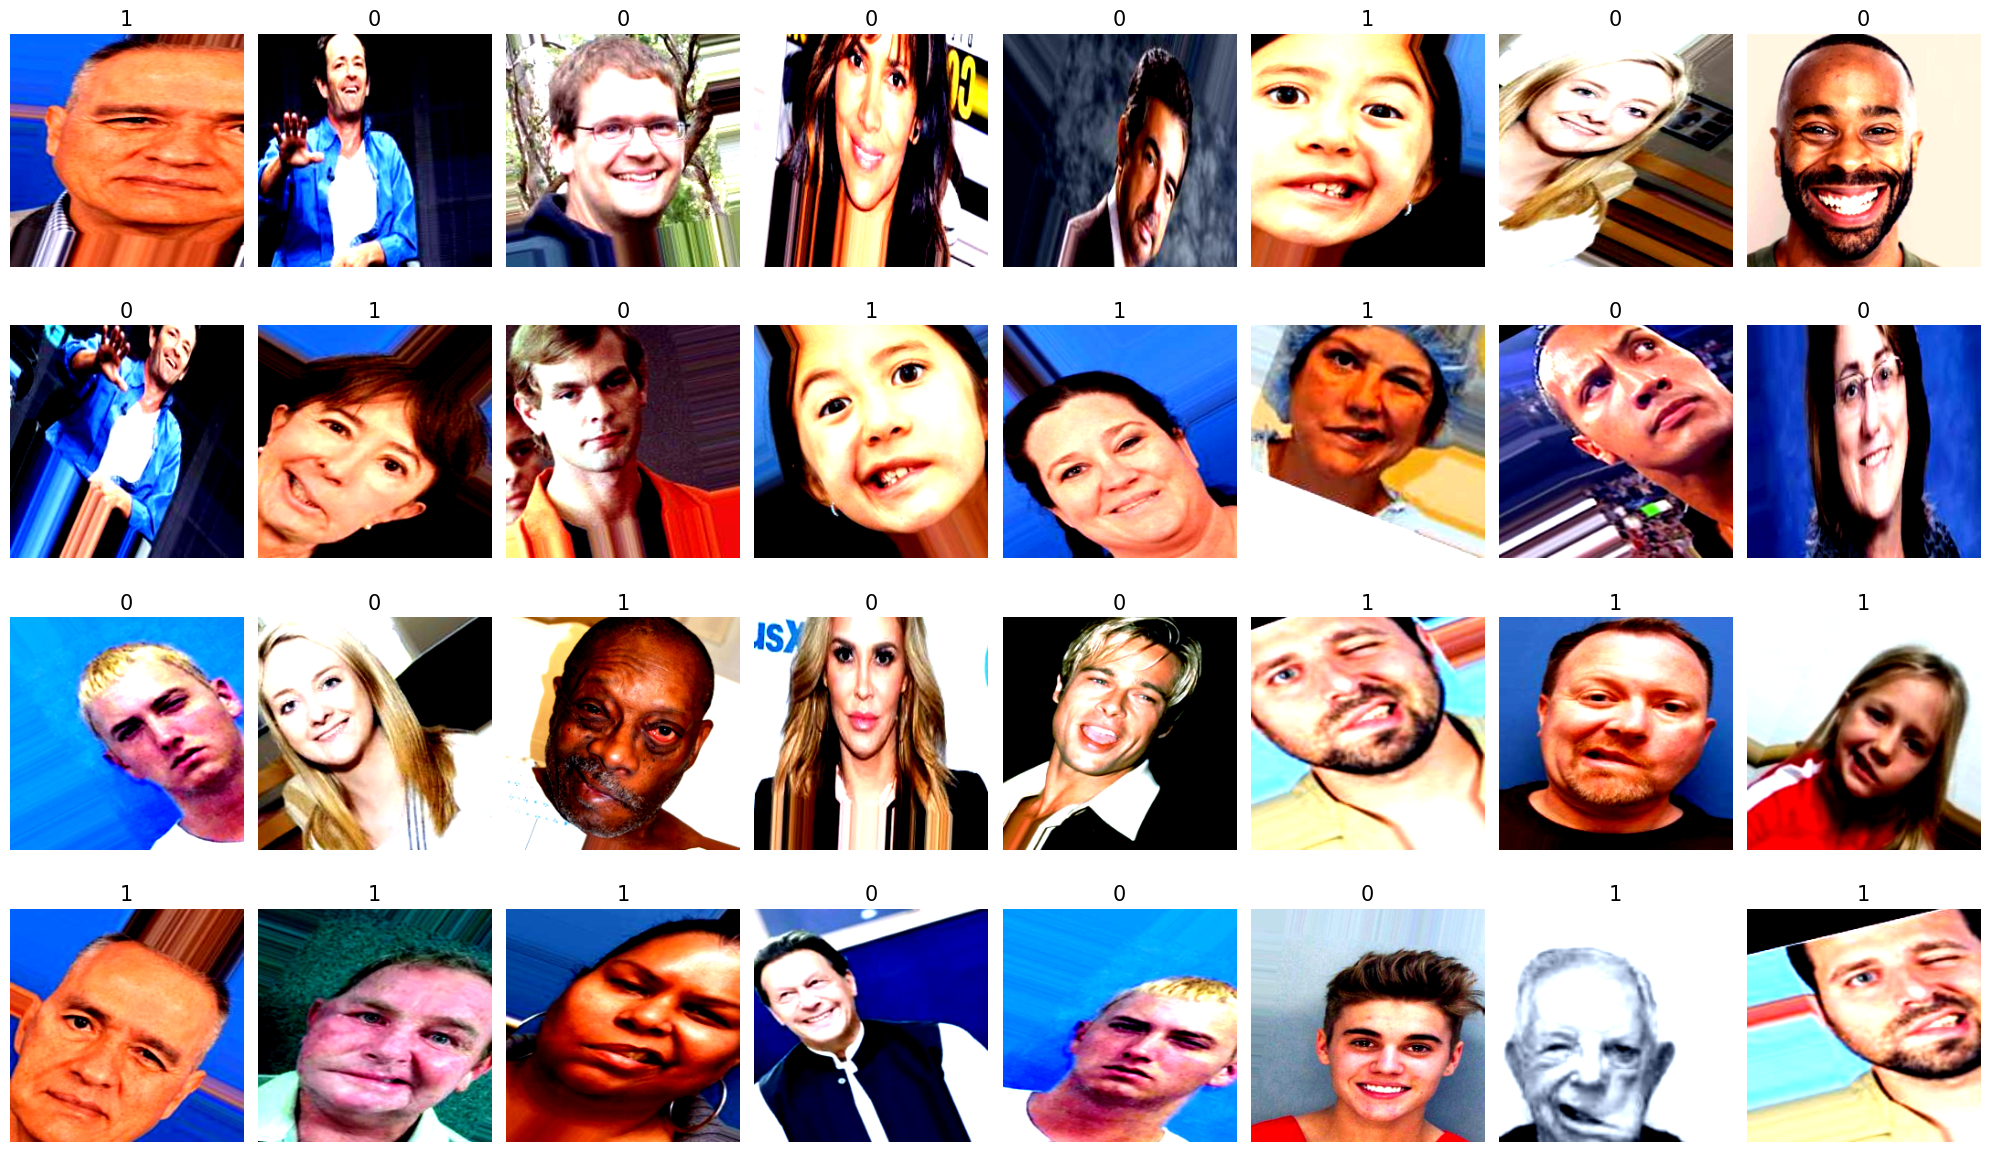

In [29]:
# Function to unnormalize and convert tensor image to numpy for plotting
def imshow(img):
    # Unnormalize: if you applied normalization before, reverse it here
    img = img / 2 + 0.5  # Assuming the image was normalized (this step can change based on your normalization)
    np_img = img.numpy()  # Convert tensor to numpy
    np_img = np.transpose(np_img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    return np_img

# Create a figure with 4x8 subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 12))
axes = axes.flatten()

# Set a seed for reproducibility and select random 32 indices from the training set
np.random.seed(42)
idx = np.random.choice(len(train_data), size=32, replace=False)

# Loop over the selected indices and plot the images with titles
for i, ix in enumerate(idx):
    axes[i].axis('off')  # Hide axes ticks
    image, label = train_data[ix]  # Get the image and label from the train dataset
    axes[i].imshow(imshow(image))  # Plot the unnormalized image
    axes[i].set_title(str(int(label)), color='black', fontsize=15)  # Set title as label (stroke/no stroke)

# Display the plot
plt.tight_layout()
plt.show()

Set up the ResNet50

In [42]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MyResNet (ResNet):
    def __init__(self, 
                 block = BasicBlock,
                 layers = [2, 2, 2, 2],
                 num_classes = 2):
        super(MyResNet, self).__init__(block,
                                       layers,
                                       num_classes = num_classes)
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3, bias = False)
        
        '''
        you can modify the layers in this initialization of ResNet if you like
        '''
        
#Choose 1
resnet18 = {
    'block': BasicBlock,
    'layers': [2, 2, 2, 2]
}

resnet34 = {
    'block': BasicBlock,
    'layers': [3, 4, 6, 3]
}

resnet50 = {
    'block' : Bottleneck,
    'layers' : [3, 4, 6, 3]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyResNet(**resnet50).to(device)

In [12]:
%pip install torchinfo -q
import torchinfo

Note: you may need to restart the kernel to use updated packages.


Summary of the model

In [43]:
from torchinfo import summary # similiar function to tensorflow/keras summary for torch
model.to(device)
summary(model, input_size = (batch_size, 3, 28, 28), device = 'cpu') # (color_channel, 28, 28)

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [16, 2]                   --
├─Conv2d: 1-1                            [16, 64, 28, 28]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 28, 28]          128
├─ReLU: 1-3                              [16, 64, 28, 28]          --
├─MaxPool2d: 1-4                         [16, 64, 14, 14]          --
├─Sequential: 1-5                        [16, 256, 14, 14]         --
│    └─Bottleneck: 2-1                   [16, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [16, 64, 14, 14]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 14, 14]          128
│    │    └─ReLU: 3-3                    [16, 64, 14, 14]          --
│    │    └─Conv2d: 3-4                  [16, 64, 14, 14]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 14, 14]          128
│    │    └─ReLU: 3-6                    [16, 64, 14, 14]          --
│ 

Move to GPU

In [44]:
print("Is GPU available: ", torch.cuda.is_available())

Is GPU available:  True


Set up the training with optimizer

In [47]:
# Use AdamW optimizer
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 100
acc_last_epoch = 0.0
acc_max = 0.0

Train and validate

In [67]:
from tqdm.auto import tqdm


# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    
    # Initialize the progress bar for training
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for x, targets in train_loader:
            # Move inputs and targets to the GPU
            x, targets = x.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = loss_func(outputs, targets)
            
            # Backward pass and optimizer step
            optimizer.zero_grad()  # Clear the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights
            
            # Update the progress bar description with the current loss
            pbar.set_postfix(loss=loss.item())
            pbar.update()  # Update the progress bar after each batch

    # Validation loop with tqdm progress bar
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():  # Disable gradient calculation
        with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{epochs}', unit='batch') as pbar_val:
            for x_v, y_v in val_loader:
                # Move validation data to the GPU
                x_v, y_v = x_v.to(device), y_v.to(device)
                yhat = model(x_v)
                yhat = yhat.argmax(dim=-1)

                # Calculate validation loss and accuracy
                val_loss += loss_func(model(x_v), y_v).item()
                val_acc += (yhat == y_v).float().mean().item()

                # Update the progress bar for validation
                pbar_val.update()

    # Average the validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f'Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Validation Epoch 1/100: 100%|██████████| 36/36 [00:04<00:00,  7.60batch/s]


Epoch 1/100 - Validation Loss: 0.3353, Validation Accuracy: 0.8993


Validation Epoch 2/100: 100%|██████████| 36/36 [00:04<00:00,  7.72batch/s]


Epoch 2/100 - Validation Loss: 0.3403, Validation Accuracy: 0.9076


Validation Epoch 3/100: 100%|██████████| 36/36 [00:04<00:00,  7.80batch/s]


Epoch 3/100 - Validation Loss: 0.2207, Validation Accuracy: 0.9097


Validation Epoch 4/100: 100%|██████████| 36/36 [00:04<00:00,  7.72batch/s]


Epoch 4/100 - Validation Loss: 0.2047, Validation Accuracy: 0.9045


Validation Epoch 5/100: 100%|██████████| 36/36 [00:04<00:00,  7.72batch/s]


Epoch 5/100 - Validation Loss: 0.6846, Validation Accuracy: 0.8486


Validation Epoch 6/100: 100%|██████████| 36/36 [00:04<00:00,  7.84batch/s]


Epoch 6/100 - Validation Loss: 0.0719, Validation Accuracy: 0.9670


Validation Epoch 7/100: 100%|██████████| 36/36 [00:04<00:00,  7.67batch/s]


Epoch 7/100 - Validation Loss: 0.0278, Validation Accuracy: 0.9878


Validation Epoch 8/100: 100%|██████████| 36/36 [00:04<00:00,  7.80batch/s]


Epoch 8/100 - Validation Loss: 0.2976, Validation Accuracy: 0.8556


Validation Epoch 9/100: 100%|██████████| 36/36 [00:04<00:00,  7.64batch/s]


Epoch 9/100 - Validation Loss: 0.0724, Validation Accuracy: 0.9774


Validation Epoch 10/100: 100%|██████████| 36/36 [00:04<00:00,  7.53batch/s]


Epoch 10/100 - Validation Loss: 0.0719, Validation Accuracy: 0.9688


Validation Epoch 11/100: 100%|██████████| 36/36 [00:04<00:00,  7.48batch/s]


Epoch 11/100 - Validation Loss: 0.0139, Validation Accuracy: 0.9983


Validation Epoch 12/100: 100%|██████████| 36/36 [00:05<00:00,  6.33batch/s]


Epoch 12/100 - Validation Loss: 0.0409, Validation Accuracy: 0.9844


Validation Epoch 13/100: 100%|██████████| 36/36 [00:04<00:00,  7.23batch/s]


Epoch 13/100 - Validation Loss: 0.0309, Validation Accuracy: 0.9896


Validation Epoch 14/100: 100%|██████████| 36/36 [00:04<00:00,  7.59batch/s]


Epoch 14/100 - Validation Loss: 0.0442, Validation Accuracy: 0.9878


Epoch 15/100:   0%|          | 0/165 [00:00<?, ?batch/s]


KeyboardInterrupt: 

In [61]:
from tqdm.auto import tqdm

# Training loop
for epoch in range(epochs):
    
    model.train()
    
    loss_vals = []
    acc_on_valid = [0.0]
    
    with tqdm(total=len(train_loader)) as pbar:
        for x, targets in train_loader:
            x, targets = x.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(x)
            
            # Loss calculation
            loss = loss_func(outputs, targets)
            loss_vals.append(loss.item())
            
            # Opitmizer
            optimizer.zero_grad()  # Clear the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights
            
            desc = f"epoch: [{epoch+1}/{epochs}] | loss: {np.mean(loss_vals):.4f}"
            desc += f"| acc on valid: {acc_last_epoch:.2f}"
            pbar.set_description(desc)
            pbar.update()

    # Validation
    model.eval()
    with torch.no_grad():
        for x_v, y_v in val_loader:
            x_v, y_v = x_v.to(device), y_v.to(device)
            yhat = model(x_v)
            yhat = yhat.argmax(dim=-1)
            acc = (yhat == y_v).float().mean()
            acc = acc.cpu().numpy()
            acc_on_valid.append(acc)
        
        acc_last_epoch = np.mean(acc_on_valid)

        # Save the model if it improves
        if acc_last_epoch > acc_max:
            torch.save(model.state_dict(), 'my_model.pt')
            acc_max = acc_last_epoch

    print(f'Epoch [{epoch+1}/{epochs}] - Validation Accuracy: {acc_last_epoch:.4f}')

  0%|          | 0/165 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Citation 

Shuhao Cao. (2023). UMKC 2023 Fall CS 5590 / Math 5555 Optimization. Kaggle. https://kaggle.com/competitions/umkc-2023-fall-cs-5590-math-5555-optimization